In [1]:
import numpy as np
import torch
import torchvision.transforms as T
from PIL import Image
import os
import cv2
import json
import glob
from tqdm.notebook import tqdm

In [22]:
import os

cwd = os.getcwd()
ROOT_DIR = os.path.join(cwd, "data_classification")

labels = {}

# Walk through all folders (train/test) and subfolders (Positive/Negative)
for split in os.listdir(ROOT_DIR):  # e.g., 'train', 'test'
    split_path = os.path.join(ROOT_DIR, split)
    if not os.path.isdir(split_path):
        continue

    for class_folder in os.listdir(split_path):  # e.g., 'Positive', 'Negative'
        class_path = os.path.join(split_path, class_folder)
        if not os.path.isdir(class_path):
            continue

        for file in os.listdir(class_path):
            if file.lower().endswith((".jpg", ".jpeg", ".png")):
                full_path = os.path.join(class_path, file)
                # label includes both split and class for clarity
                labels[full_path] = class_folder

files = list(labels.keys())

print(f"Found {len(files)} image files across all splits.")
print(f"Classes: {set(labels.values())}")


Found 867 image files across all splits.
Classes: {'Positive', 'Negative'}


In [24]:
dinov2_vits14 = torch.hub.load("facebookresearch/dinov2", "dinov2_vits14")

device = torch.device('cuda' if torch.cuda.is_available() else "cpu")

dinov2_vits14.to(device)

transform_image = T.Compose([T.ToTensor(), T.Resize(244), T.CenterCrop(224), T.Normalize([0.5], [0.5])])

Using cache found in /home/ai-17/.cache/torch/hub/facebookresearch_dinov2_main


In [28]:
def load_image(img: str) -> torch.Tensor:
    """
    Load an image and return a tensor that can be used as an input to DINOv2.
    """
    img = Image.open(img).convert("RGB")

    transformed_img = transform_image(img)[:3].unsqueeze(0)

    return transformed_img

import warnings
import numpy as np
import torch
from PIL import Image, ImageFile, ImageOps
import cv2

ImageFile.LOAD_TRUNCATED_IMAGES = False  # start strict; we'll toggle per-attempt

def safe_open_pil(path):
    # strict PIL first
    with Image.open(path) as im:
        im.load()  # force decoding to catch errors early
        return im.copy()

def safe_open_pil_truncated(path):
    # tolerant PIL
    ImageFile.LOAD_TRUNCATED_IMAGES = True
    try:
        with Image.open(path) as im:
            im.load()
            return im.copy()
    finally:
        ImageFile.LOAD_TRUNCATED_IMAGES = False

def safe_open_cv(path):
    data = np.fromfile(path, dtype=np.uint8)   # handles weird paths
    img = cv2.imdecode(data, cv2.IMREAD_COLOR) # BGR uint8
    if img is None:
        raise OSError("cv2.imdecode failed")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return Image.fromarray(img)

def open_image_robust(path):
    # Try strict PIL
    try:
        im = safe_open_pil(path)
    except Exception:
        # Try tolerant PIL
        try:
            im = safe_open_pil_truncated(path)
        except Exception:
            # Try OpenCV
            im = safe_open_cv(path)

    # Normalize mode & orientation
    try:
        im = ImageOps.exif_transpose(im)
    except Exception:
        pass

    if im.mode not in ("RGB", "L"):
        # handle CMYK, RGBA, P, etc.
        im = im.convert("RGB")
    elif im.mode == "L":
        im = im.convert("RGB")
    return im

def load_image(img_path: str) -> torch.Tensor:
    """
    Robust loader -> transform -> [1, 3, H, W]
    """
    img = open_image_robust(img_path)      # PIL.Image RGB
    tensor = transform_image(img)          # expected [3, H, W]
    return tensor.unsqueeze(0)


def compute_embeddings(files: list) -> dict:
    all_embeddings = {}
    dinov2_vits14.eval()
    with torch.no_grad():
        for f in tqdm(files, desc="Computing embeddings"):
            try:
                img_tensor = load_image(f).to(device)
                emb = dinov2_vits14(img_tensor)
                all_embeddings[f] = emb[0].cpu().numpy().reshape(1, -1).tolist()
            except Exception as e:
                # log and continue
                print(f"[WARN] Skipping {f}: {e}")
    with open("all_embeddings.json", "w") as fp:
        json.dump(all_embeddings, fp)
    return all_embeddings


In [29]:
embeddings = compute_embeddings(files)

Computing embeddings:   0%|          | 0/867 [00:00<?, ?it/s]

In [31]:
# embeddings

In [32]:
from sklearn import svm

clf = svm.SVC(gamma='scale')

y = [labels[file] for file in files]

embedding_list = list(embeddings.values())

clf.fit(np.array(embedding_list).reshape(-1, 384), y)

,C,1.0
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [36]:
import supervision as sv

input_file = "data_classification/test/Positive/FC1164-11_phase_split_463.jpeg"

new_image = load_image(input_file)

with torch.no_grad():
    embedding = dinov2_vits14(new_image.to(device))

    prediction = clf.predict(np.array(embedding[0].cpu()).reshape(1, -1))

    print()
    print("Predicted class: " + prediction[0])


Predicted class: Negative


In [37]:
import os
from pathlib import Path
from typing import List
import numpy as np
import torch
from tqdm import tqdm
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
)

# Assumes you already have:
# - load_image(img_path) -> Tensor [1,3,H,W]
# - dinov2_vits14 model
# - device (e.g., torch.device('cuda' or 'cpu'))
# - clf (your trained classifier)

IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff", ".webp"}

def iter_images_with_labels(root: str) -> List[tuple]:
    """
    Yields (path, label) where label is the immediate parent folder name under root.
    Expects structure: root/<class_name>/*.jpg
    """
    root_path = Path(root)
    items = []
    for class_dir in sorted([p for p in root_path.iterdir() if p.is_dir()]):
        label = class_dir.name
        for p in class_dir.iterdir():
            if p.is_file() and p.suffix.lower() in IMG_EXTS:
                items.append((str(p), label))
    return items

def embed_image(path: str) -> np.ndarray:
    """
    Load -> embed with DINOv2 -> return 1D numpy array (1 x D).
    """
    with torch.no_grad():
        x = load_image(path).to(device)           # [1,3,H,W]
        emb = dinov2_vits14(x)                    # [1, D] (assumed)
        vec = emb[0].detach().cpu().numpy().reshape(1, -1)  # (1, D)
    return vec

def evaluate(test_root="data_classification/test"):
    # Put backbone in eval mode
    dinov2_vits14.eval()

    samples = iter_images_with_labels(test_root)
    if not samples:
        raise RuntimeError(f"No test images found under: {test_root}")

    y_true, y_pred = [], []
    y_score = []  # optional for ROC-AUC (binary)

    # Optional: map/normalize class names to match clf.classes_ if needed
    # Here we assume folder names match your training labels exactly.

    # If classifier supports proba, remember index of the positive class for ROC
    has_proba = hasattr(clf, "predict_proba")
    pos_class_name = None
    pos_index = None
    if has_proba and getattr(clf, "classes_", None) is not None and len(clf.classes_) == 2:
        # pick Positive if available, otherwise first class is treated as positive
        if "Positive" in clf.classes_:
            pos_class_name = "Positive"
            pos_index = int(np.where(clf.classes_ == "Positive")[0][0])
        else:
            pos_class_name = clf.classes_[1]
            pos_index = 1

    for path, label in tqdm(samples, desc="Evaluating test set"):
        try:
            vec = embed_image(path)  # (1, D)
            pred = clf.predict(vec)[0]
            y_true.append(label)
            y_pred.append(pred)

            if has_proba and pos_index is not None:
                proba = clf.predict_proba(vec)[0][pos_index]
                y_score.append(float(proba))
        except Exception as e:
            # Skip unreadable/corrupt files but don’t crash evaluation
            print(f"[WARN] Skipping {path}: {e}")

    # Basic metrics
    acc = accuracy_score(y_true, y_pred)
    print("\n=== Results ===")
    print(f"Samples: {len(y_true)}")
    print(f"Accuracy: {acc:.4f}\n")

    print("Per-class metrics:")
    print(classification_report(y_true, y_pred, digits=4))

    # Confusion matrix
    labels_sorted = sorted(list(set(y_true) | set(y_pred)))
    cm = confusion_matrix(y_true, y_pred, labels=labels_sorted)
    print("Confusion Matrix (rows=true, cols=pred):")
    print("Labels order:", labels_sorted)
    print(cm)

    # ROC-AUC (binary only, if proba available)
    if has_proba and pos_index is not None and len(set(y_true)) == 2:
        # Convert y_true to 0/1 with positive = pos_class_name
        y_true_bin = [1 if y == pos_class_name else 0 for y in y_true]
        try:
            auc = roc_auc_score(y_true_bin, y_score)
            print(f"\nROC-AUC (positive='{pos_class_name}'): {auc:.4f}")
        except Exception as e:
            print(f"[INFO] ROC-AUC not computed: {e}")

    return {
        "accuracy": acc,
        "labels_order": labels_sorted,
        "confusion_matrix": cm,
    }

metrics = evaluate("data_classification/test")


Evaluating test set: 100%|██████████| 217/217 [00:26<00:00,  8.26it/s]


=== Results ===
Samples: 217
Accuracy: 0.8802

Per-class metrics:
              precision    recall  f1-score   support

    Negative     0.9172    0.9172    0.9172       157
    Positive     0.7833    0.7833    0.7833        60

    accuracy                         0.8802       217
   macro avg     0.8503    0.8503    0.8503       217
weighted avg     0.8802    0.8802    0.8802       217

Confusion Matrix (rows=true, cols=pred):
Labels order: ['Negative', 'Positive']
[[144  13]
 [ 13  47]]


In [38]:
metrics

{'accuracy': 0.880184331797235,
 'labels_order': ['Negative', 'Positive'],
 'confusion_matrix': array([[144,  13],
        [ 13,  47]])}

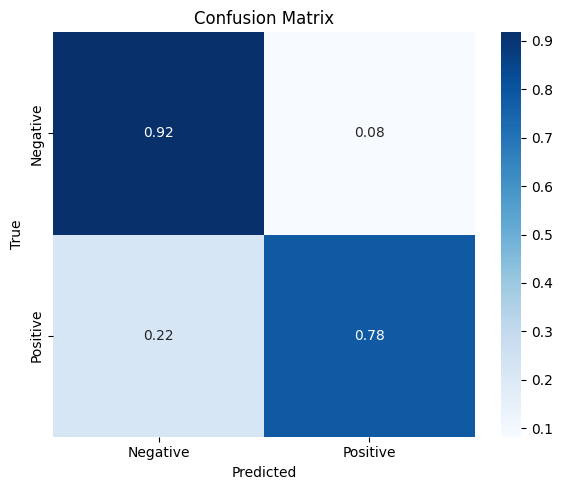

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(cm, labels, normalize=True):
    """Plot confusion matrix as heatmap."""
    if normalize:
        cm = cm.astype(float) / cm.sum(axis=1, keepdims=True)
        fmt = ".2f"
    else:
        fmt = "d"
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt=fmt, cmap="Blues",
                xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()


plot_confusion_matrix(metrics['confusion_matrix'], labels=metrics['labels_order'])

In [46]:
import numpy as np

def metrics_from_confusion_matrix(cm: np.ndarray, labels: list):
    """
    Compute per-class and macro-averaged precision, recall, and F1-score
    from a confusion matrix.
    
    Args:
        cm (np.ndarray): confusion matrix (rows=true labels, cols=predicted)
        labels (list): list of class names in the same order as cm axes
    """
    cm = np.asarray(cm)
    assert cm.shape[0] == cm.shape[1], "Confusion matrix must be square"
    n_classes = cm.shape[0]

    precisions, recalls, f1s = [], [], []

    for i in range(n_classes):
        tp = cm[i, i]
        fp = cm[:, i].sum() - tp
        fn = cm[i, :].sum() - tp

        precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0

        precisions.append(precision)
        recalls.append(recall)
        f1s.append(f1)

        print(f"Class '{labels[i]}': "
              f"Precision={precision:.4f}, Recall={recall:.4f}, F1={f1:.4f}")

    # Macro averages (unweighted)
    macro_precision = np.mean(precisions)
    macro_recall = np.mean(recalls)
    macro_f1 = np.mean(f1s)

    print("\nMacro-Average Metrics:")
    print(f"Precision={macro_precision:.4f}, Recall={macro_recall:.4f}, F1={macro_f1:.4f}")

    return {
        "per_class": dict(zip(labels, zip(precisions, recalls, f1s))),
        "macro_avg": {
            "precision": macro_precision,
            "recall": macro_recall,
            "f1": macro_f1
        }
    }


metrics_from_confusion_matrix(metrics['confusion_matrix'], metrics['labels_order'])

Class 'Negative': Precision=0.9172, Recall=0.9172, F1=0.9172
Class 'Positive': Precision=0.7833, Recall=0.7833, F1=0.7833

Macro-Average Metrics:
Precision=0.8503, Recall=0.8503, F1=0.8503


{'per_class': {'Negative': (np.float64(0.9171974522292994),
   np.float64(0.9171974522292994),
   np.float64(0.9171974522292994)),
  'Positive': (np.float64(0.7833333333333333),
   np.float64(0.7833333333333333),
   np.float64(0.7833333333333333))},
 'macro_avg': {'precision': np.float64(0.8502653927813164),
  'recall': np.float64(0.8502653927813164),
  'f1': np.float64(0.8502653927813164)}}